Step 1:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 2: Load Data Files

In [ ]:
import pandas as pd

# Load sentiment data
sentiment = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment/CSV_files/fear_greed_index.csv')

# Load trading data
trader = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Assignment/CSV_files/historical_data.csv")

Step 3: Check Data Shapes and Basic Info

In [ ]:
print('Trader rows, cols:', trader.shape)
print('Sentiment rows, cols:', sentiment.shape)

print(sentiment.head())
print(trader.head())
print(trader.info())

Trader rows, cols: (211224, 16)
Sentiment rows, cols: (2644, 4)
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.5245

Step 4: Convert Timestamps to Datetime Format

In [ ]:
trader['Timestamp IST'] = pd.to_datetime(trader['Timestamp IST'], format='%d-%m-%Y %H:%M')
sentiment['date'] = pd.to_datetime(sentiment['date'])

Step 5: Extract Temporal Features

In [ ]:
trader['date'] = trader['Timestamp IST'].dt.date
trader['hour'] = trader['Timestamp IST'].dt.hour
print(trader[['Timestamp IST','date','hour']].head())




        Timestamp IST        date  hour
0 2024-12-02 22:50:00  2024-12-02    22
1 2024-12-02 22:50:00  2024-12-02    22
2 2024-12-02 22:50:00  2024-12-02    22
3 2024-12-02 22:50:00  2024-12-02    22
4 2024-12-02 22:50:00  2024-12-02    22


Step 6: Convert Numeric Columns

In [ ]:
def to_numeric(col):
    return pd.to_numeric(trader[col], errors='coerce')

for col in ['Closed PnL', 'Closed PnL', 'Size Tokens', 'Execution Price']:
    if col in trader.columns:
        trader[col] = to_numeric(col)

# Convert additional numeric columns
num_cols = ['Execution Price', 'Size Tokens', 'Size USD', 'Start Position', 'Closed PnL', 'Fee']
for col in num_cols:
    trader[col] = pd.to_numeric(trader[col], errors='coerce')

print(trader[['Execution Price', 'Size Tokens', 'Size USD']].head())

   Execution Price  Size Tokens  Size USD
0           7.9769       986.87   7872.16
1           7.9800        16.00    127.68
2           7.9855       144.09   1150.63
3           7.9874       142.98   1142.04
4           7.9894         8.73     69.75


Step 7: Analyze Trade Directions

['Buy' 'Sell' 'Open Long' 'Close Long' 'Spot Dust Conversion' 'Open Short'
 'Close Short' 'Long > Short' 'Short > Long' 'Auto-Deleveraging'
 'Liquidated Isolated Short' 'Settlement']


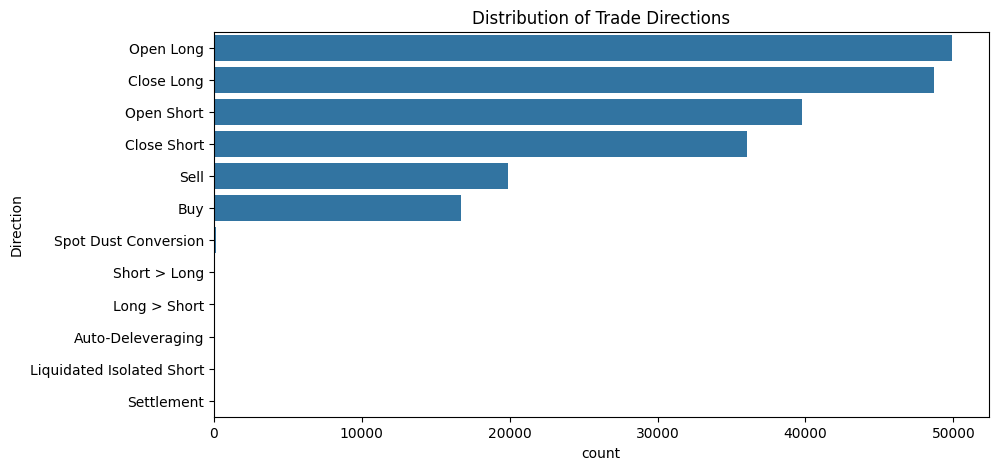

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
print(trader['Direction'].unique())

# Plot distribution of trade directions
plt.figure(figsize=(10,5))
sns.countplot(y='Direction', data=trader, order=trader['Direction'].value_counts().index)
plt.title('Distribution of Trade Directions')
plt.show()

Step 8: Classify Trades into Categories

In [ ]:
# Define keyword lists for classification
open_keywords   = ['Open', 'Buy', 'Sell', 'Open Long', 'Open Short']
close_keywords  = ['Close', 'Close Long', 'Close Short', 'Settlement']
dust_keywords   = ['dust','Spot Dust Conversion']

def classify_trade(row):
    direction = row['Direction']
    pnl = row['Closed PnL']
    tx = row['Transaction Hash']
    size_usd = row['Size USD']

    # --- Closed Trades ---
    if any(k in direction for k in close_keywords) and pd.notna(pnl):
        return 'Closed'

    # --- Open Trades ---
    if any(k in direction for k in open_keywords) and (pnl == 0 or pd.isna(pnl)):
        return 'Open'

    # --- System Events ---
    if any(k in direction for k in dust_keywords) or str(tx).startswith('0x0') or (size_usd < 1):
        return 'System'

    return 'Other'

# Apply the classification
trader['category'] = trader.apply(classify_trade, axis=1)
print(trader['category'].value_counts())

category
Open      106608
Closed     84692
Other      15432
System      4492
Name: count, dtype: int64


Step 9: Separate Data by Trade Categories

In [ ]:
closed_trades  = trader[trader['category'] == 'Closed'].copy()
open_trades    = trader[trader['category'] == 'Open'].copy()
system_events  = trader[trader['category'] == 'System'].copy()

print(f"Closed: {len(closed_trades)} | Open: {len(open_trades)} | System: {len(system_events)}")

Closed: 84692 | Open: 106608 | System: 4492


Step 10: Save Processed Data

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/Assignment/CSV_files'
closed_trades.to_csv(save_path + 'closed_trades.csv', index=False)
open_trades.to_csv(save_path + 'open_trades.csv', index=False)
system_events.to_csv(save_path + 'system_events.csv', index=False)

Step 11: Data Scaling for Analysis

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Identify numeric columns
numeric_cols = closed_trades.select_dtypes(include=['float64', 'int64']).columns
print("Numeric columns:\n", numeric_cols.tolist())

# Remove unnecessary columns
drop_cols = ['order_id', 'trade_id']
closed_trades = closed_trades.drop(columns=[c for c in drop_cols if c in closed_trades.columns], errors='ignore')

# Check for extremely large values
large_cols = [c for c in numeric_cols if closed_trades[c].abs().max() > 1e10]
print("Columns with extremely large values:", large_cols)

# Scale numeric features
scaler = MinMaxScaler()
cols_to_scale = ['Execution Price', 'Size USD', 'Closed PnL']
closed_trades[cols_to_scale] = scaler.fit_transform(closed_trades[cols_to_scale])

print(closed_trades.head())

Numeric columns:
 ['Execution Price', 'Size Tokens', 'Size USD', 'Start Position', 'Closed PnL', 'Order ID', 'Fee', 'Trade ID', 'Timestamp']
Columns with extremely large values: ['Order ID', 'Trade ID', 'Timestamp']
                                        Account  Coin  Execution Price  \
142  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  AAVE         0.002237   
143  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  AAVE         0.002237   
144  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  AAVE         0.002237   
145  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  AAVE         0.002236   
146  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  AAVE         0.002236   

     Size Tokens  Size USD  Side       Timestamp IST  Start Position  \
142        14.78  0.000914  SELL 2024-12-03 20:56:00         1000.00   
143         8.65  0.000535  SELL 2024-12-03 20:56:00          985.22   
144        13.67  0.000845  SELL 2024-12-03 20:56:00          976.57   
145         0.06  0.000004  SELL 2024-12-03 20:56:0

Step 12: Prepare Sentiment Data

In [ ]:
# Reload sentiment data and clean it
sentiment = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment/CSV_files/fear_greed_index.csv')

# Clean column names
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(' ', '_')
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce').dt.date
sentiment.rename(columns={'classification': 'sentiment'}, inplace=True)

Step 13: Add Trade Date for Merging

In [ ]:
closed_trades['trade_date'] = pd.to_datetime(closed_trades['Timestamp IST'], errors='coerce').dt.date

Step 14: Merge Trading Data with Sentiment Data

In [ ]:
merged = pd.merge(
    closed_trades,
    sentiment[['date', 'sentiment']],
    left_on='trade_date',
    right_on='date',
    how='left'
)

print("Merged rows:", len(merged))
print("Unique sentiments:", merged['sentiment'].unique())

Merged rows: 84692
Unique sentiments: ['Extreme Greed' 'Extreme Fear' 'Fear' 'Greed' nan 'Neutral']


In [ ]:
# Get the actual values for dataset overview
print("📊 DATASET OVERVIEW")

# Total trades analyzed
total_trades = len(merged)
print(f"Total trades analyzed: {total_trades:,} closed trades")

# Date range
date_range_start = merged['trade_date'].min()
date_range_end = merged['trade_date'].max()
print(f"Date range: {date_range_start} to {date_range_end}")

# Unique coins traded
unique_coins = merged['Coin'].nunique()
print(f"Unique coins traded: {unique_coins} different cryptocurrencies")

# Unique trading accounts
unique_accounts = merged['Account'].nunique()
print(f"Unique trading accounts: {unique_accounts} trading accounts")

# Additional metrics
print(f"\n📈 ADDITIONAL METRICS:")
print(f"Trading period: {(pd.to_datetime(date_range_end) - pd.to_datetime(date_range_start)).days} days")
print(f"Average trades per day: {total_trades/((pd.to_datetime(date_range_end) - pd.to_datetime(date_range_start)).days):.1f}")

# Check data completeness
missing_sentiment = merged['sentiment'].isna().sum()
print(f"Data completeness: {(total_trades - missing_sentiment)/total_trades*100:.1f}% sentiment data available")

📊 DATASET OVERVIEW
Total trades analyzed: 84,692 closed trades
Date range: 2023-12-14 to 2025-05-01
Unique coins traded: 168 different cryptocurrencies
Unique trading accounts: 32 trading accounts

📈 ADDITIONAL METRICS:
Trading period: 504 days
Average trades per day: 168.0
Data completeness: 100.0% sentiment data available


Step 15: Exploratory Data Analysis (EDA)

sentiment
Extreme Fear     0.466152
Extreme Greed    0.465959
Fear             0.466275
Greed            0.466049
Neutral          0.466046
Name: Closed PnL, dtype: float64


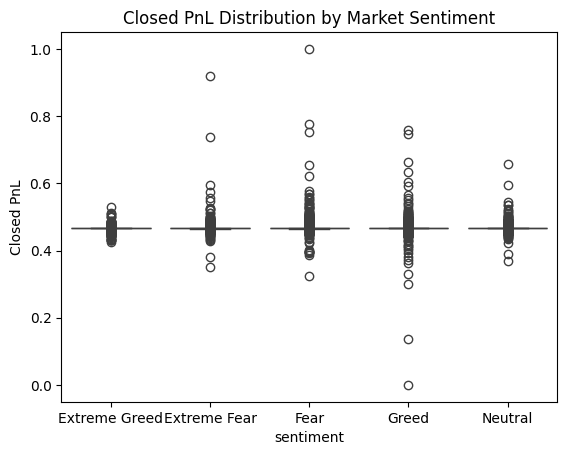

In [ ]:
# Analyze PnL by sentiment
sentiment_pnl = merged.groupby('sentiment')['Closed PnL'].mean()
print(sentiment_pnl)

# Create boxplot of PnL by sentiment
sns.boxplot(x='sentiment', y='Closed PnL', data=merged)
plt.title('Closed PnL Distribution by Market Sentiment')
plt.show()

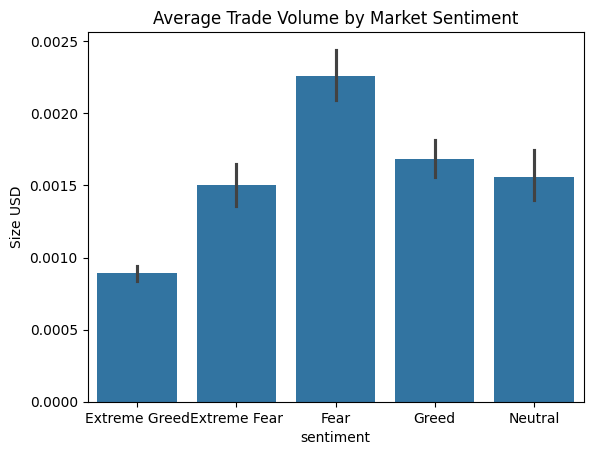

In [ ]:
sns.barplot(x='sentiment', y='Size USD', data=merged, estimator='mean')
plt.title('Average Trade Volume by Market Sentiment')
plt.show()

Step 16: More Detailed EDA and Analysis

In [ ]:
# Continue from Step 15...

# Additional analysis of sentiment vs PnL
print("\nDetailed PnL Analysis by Sentiment:")
sentiment_stats = merged.groupby('sentiment')['Closed PnL'].agg(['mean', 'std', 'count', 'min', 'max'])
print(sentiment_stats)

# Check for missing sentiment data
missing_sentiment = merged['sentiment'].isna().sum()
print(f"\nTrades with missing sentiment: {missing_sentiment} ({missing_sentiment/len(merged)*100:.2f}%)")

# Analyze trade size distribution by sentiment
if 'Size USD' in merged.columns:
    print("\nAverage Trade Size by Sentiment:")
    size_by_sentiment = merged.groupby('sentiment')['Size USD'].mean()
    print(size_by_sentiment)


Detailed PnL Analysis by Sentiment:
                   mean       std  count       min       max
sentiment                                                   
Extreme Fear   0.466152  0.006590   9358  0.349835  0.920882
Extreme Greed  0.465959  0.001690  13683  0.425276  0.528913
Fear           0.466275  0.005597  26481  0.324920  1.000000
Greed          0.466049  0.006569  19321  0.000000  0.759992
Neutral        0.466046  0.003060  15843  0.369060  0.657251

Trades with missing sentiment: 6 (0.01%)

Average Trade Size by Sentiment:
sentiment
Extreme Fear     0.001500
Extreme Greed    0.000890
Fear             0.002259
Greed            0.001687
Neutral          0.001558
Name: Size USD, dtype: float64


Step 17: Temporal Analysis


Trading Activity by Hour:
hour
19    5763
1     5464
20    4987
22    4893
23    4713
21    4647
18    4426
0     3959
8     3763
4     3638
dtype: int64


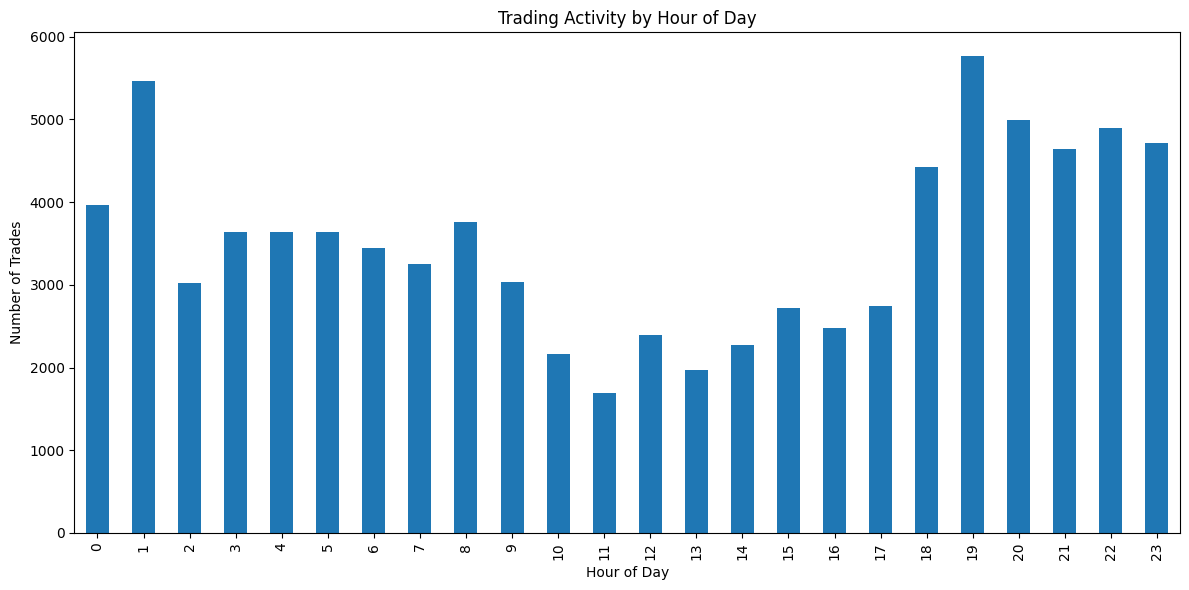

In [ ]:


# Analyze trading patterns by hour
print("\nTrading Activity by Hour:")
hourly_trades = merged.groupby('hour').size()
print(hourly_trades.sort_values(ascending=False).head(10))

# Plot hourly trading activity
plt.figure(figsize=(12, 6))
hourly_trades.plot(kind='bar')
plt.title('Trading Activity by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trades')
plt.tight_layout()
plt.show()



Step 18: Coin-wise Analysis


Most Traded Coins:
Coin
HYPE        31985
BTC         11026
ETH          5205
SOL          5016
MELANIA      2209
FARTCOIN     2162
kBONK        1164
kPEPE        1035
TRUMP         958
WLD           940
Name: count, dtype: int64

Average PnL by Top Coins:
Coin
SOL         0.467058
ETH         0.466773
MELANIA     0.466472
BTC         0.466094
HYPE        0.466017
kBONK       0.465894
WLD         0.465870
kPEPE       0.465848
FARTCOIN    0.465592
TRUMP       0.464326
Name: Closed PnL, dtype: float64


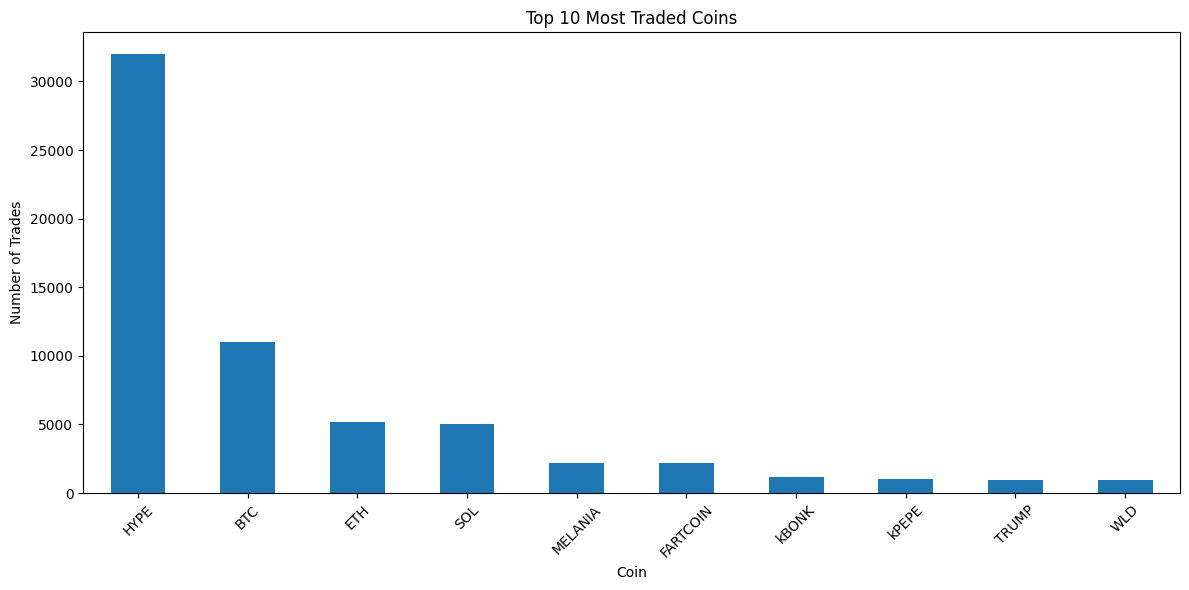

In [ ]:
# Analyze most traded coins
print("\nMost Traded Coins:")
coin_counts = merged['Coin'].value_counts()
print(coin_counts.head(10))

# Analyze PnL by coin
print("\nAverage PnL by Top Coins:")
top_coins = coin_counts.head(10).index
pnl_by_coin = merged[merged['Coin'].isin(top_coins)].groupby('Coin')['Closed PnL'].mean()
print(pnl_by_coin.sort_values(ascending=False))

# Plot top coins by trade count
plt.figure(figsize=(12, 6))
coin_counts.head(10).plot(kind='bar')
plt.title('Top 10 Most Traded Coins')
plt.xlabel('Coin')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Step 19: Advanced Sentiment Analysis


Correlation between sentiment score and PnL: -0.0188

Sentiment Distribution in Trading Data:
sentiment
Fear             26481
Greed            19321
Neutral          15843
Extreme Greed    13683
Extreme Fear      9358
Name: count, dtype: int64


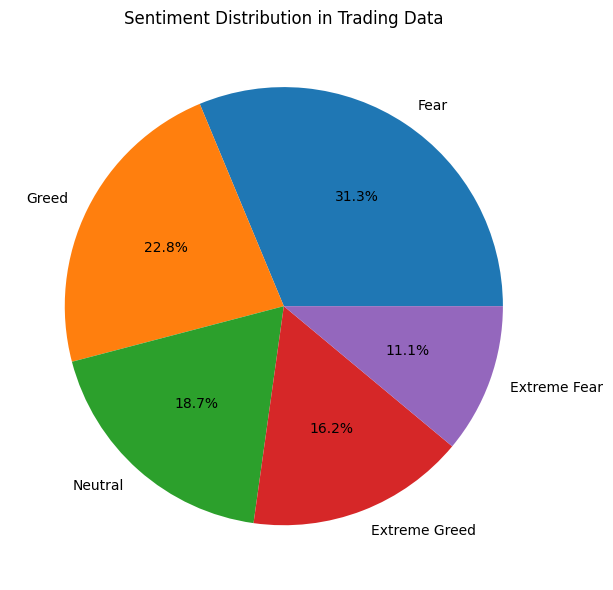

In [ ]:
# Create sentiment score mapping for quantitative analysis
sentiment_score_map = {
    'Extreme Fear': 1,
    'Fear': 2,
    'Neutral': 3,
    'Greed': 4,
    'Extreme Greed': 5
}

# Add sentiment score to merged data
merged['sentiment_score'] = merged['sentiment'].map(sentiment_score_map)

# Analyze correlation between sentiment score and PnL
if 'sentiment_score' in merged.columns:
    correlation = merged['sentiment_score'].corr(merged['Closed PnL'])
    print(f"\nCorrelation between sentiment score and PnL: {correlation:.4f}")

# Analyze sentiment distribution
print("\nSentiment Distribution in Trading Data:")
sentiment_dist = merged['sentiment'].value_counts()
print(sentiment_dist)

plt.figure(figsize=(10, 6))
sentiment_dist.plot(kind='pie', autopct='%1.1f%%')
plt.title('Sentiment Distribution in Trading Data')
plt.ylabel('')
plt.tight_layout()
plt.show()

Step 20: Fee Analysis

In [ ]:
# Analyze trading fees
if 'Fee' in merged.columns:
    print("\nFee Analysis:")
    print(f"Total fees paid: ${merged['Fee'].sum():.2f}")
    print(f"Average fee per trade: ${merged['Fee'].mean():.4f}")
    print(f"Maximum fee: ${merged['Fee'].max():.4f}")
    print(f"Minimum fee: ${merged['Fee'].min():.4f}")

    # Fees by sentiment
    print("\nAverage Fee by Sentiment:")
    fee_by_sentiment = merged.groupby('sentiment')['Fee'].mean()
    print(fee_by_sentiment)


Fee Analysis:
Total fees paid: $118814.92
Average fee per trade: $1.4029
Maximum fee: $837.4716
Minimum fee: $-1.0248

Average Fee by Sentiment:
sentiment
Extreme Fear     1.264273
Extreme Greed    0.868533
Fear             1.723937
Greed            1.465258
Neutral          1.333673
Name: Fee, dtype: float64


COST ANALYSIS


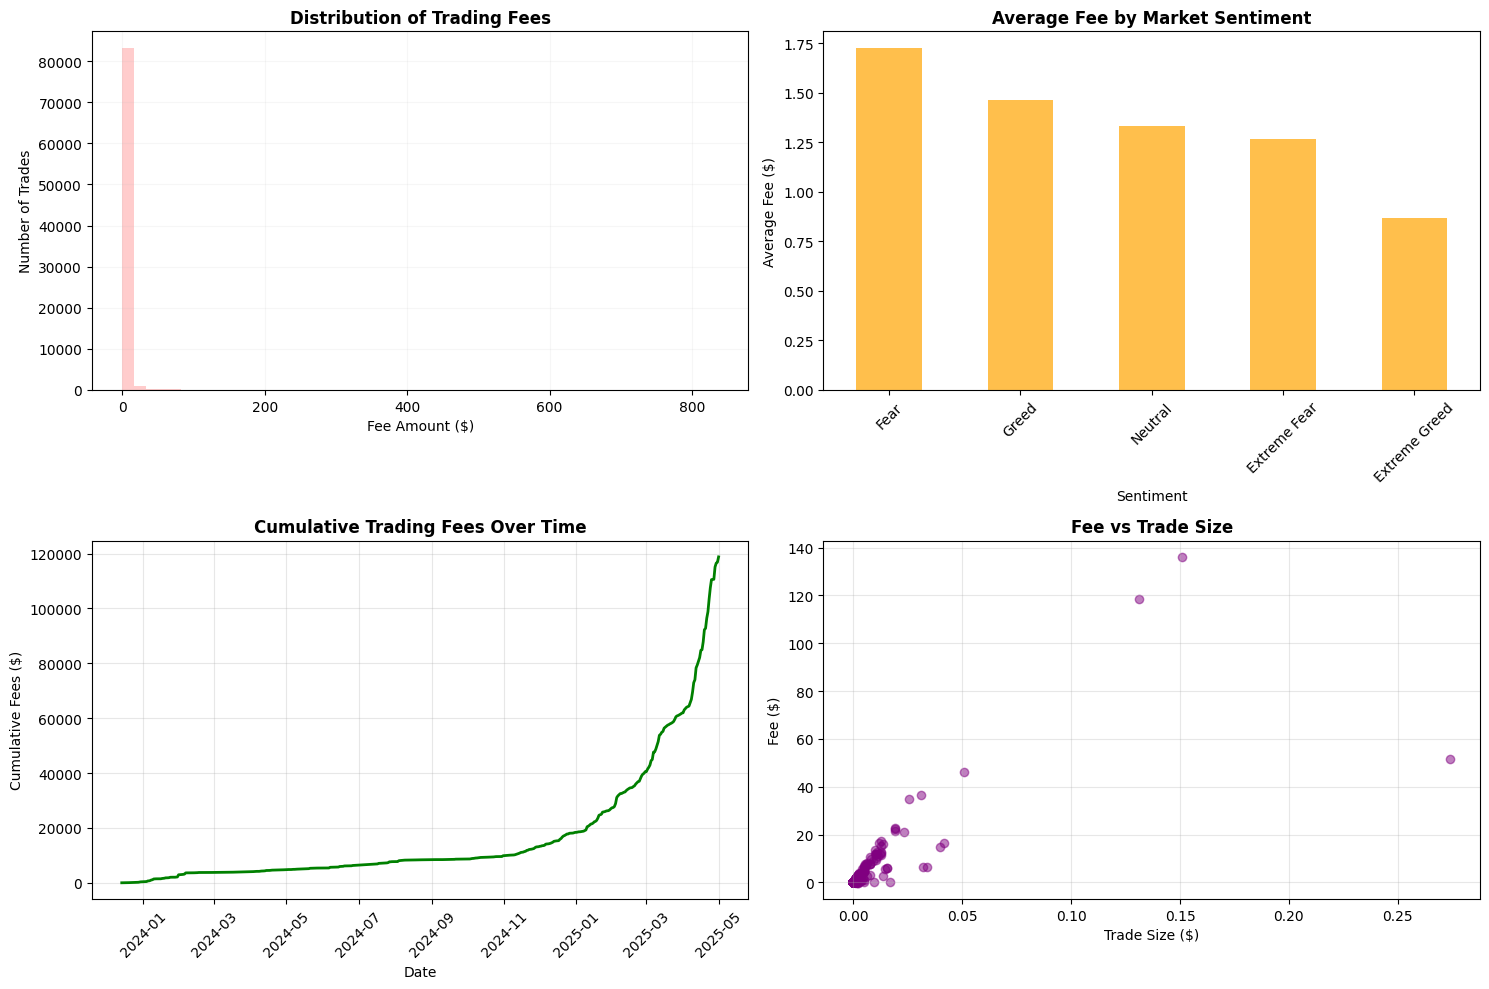

High fee trades (>95th percentile): 4235 trades
High fee threshold: $5.3154
Low fee trades (<5th percentile): 1748 trades
Low fee threshold: $0.000000


In [ ]:
# Enhanced cost analysis with visualizations
if 'Fee' in merged.columns:

    print("COST ANALYSIS")


    # Create subplots for fee analysis
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Fee distribution histogram
    merged['Fee'].hist(bins=50, ax=ax1, alpha=0.2, color='red')
    ax1.set_title('Distribution of Trading Fees', fontweight='bold')
    ax1.set_xlabel('Fee Amount ($)')
    ax1.set_ylabel('Number of Trades')
    ax1.grid(True, alpha=0.1)

    # 2. Fees by sentiment
    fee_by_sentiment = merged.groupby('sentiment')['Fee'].mean().sort_values(ascending=False)
    fee_by_sentiment.plot(kind='bar', ax=ax2, color='orange', alpha=0.7)
    ax2.set_title('Average Fee by Market Sentiment', fontweight='bold')
    ax2.set_xlabel('Sentiment')
    ax2.set_ylabel('Average Fee ($)')
    ax2.tick_params(axis='x', rotation=45)

    # 3. Cumulative fees over time
    daily_fees = merged.groupby('trade_date')['Fee'].sum().sort_index()
    daily_fees.cumsum().plot(ax=ax3, color='green', linewidth=2)
    ax3.set_title('Cumulative Trading Fees Over Time', fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Cumulative Fees ($)')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)

    # 4. Fee vs Trade Size (if available)
    if 'Size USD' in merged.columns:
        # Take a sample for better visualization
        sample_size = min(1000, len(merged))
        sample_data = merged.sample(sample_size, random_state=42)
        ax4.scatter(sample_data['Size USD'], sample_data['Fee'], alpha=0.5, color='purple')
        ax4.set_title('Fee vs Trade Size', fontweight='bold')
        ax4.set_xlabel('Trade Size ($)')
        ax4.set_ylabel('Fee ($)')
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


    # High fee analysis
    high_fee_threshold = merged['Fee'].quantile(0.95)
    high_fee_trades = merged[merged['Fee'] > high_fee_threshold]
    print(f"High fee trades (>95th percentile): {len(high_fee_trades)} trades")
    print(f"High fee threshold: ${high_fee_threshold:.4f}")

    # Low fee analysis
    low_fee_threshold = merged['Fee'].quantile(0.05)
    low_fee_trades = merged[merged['Fee'] < low_fee_threshold]
    print(f"Low fee trades (<5th percentile): {len(low_fee_trades)} trades")
    print(f"Low fee threshold: ${low_fee_threshold:.6f}")

Step 21: Account Analysis

In [ ]:
# Analyze trading behavior by account
print("\nTop Trading Accounts:")
account_counts = merged['Account'].value_counts()
print(f"Total unique accounts: {len(account_counts)}")
print(f"Top 10 accounts by trade count:")
print(account_counts.head(10))

# Analyze if certain accounts perform better
if len(account_counts) > 0:
    top_accounts = account_counts.head(20).index
    pnl_by_account = merged[merged['Account'].isin(top_accounts)].groupby('Account')['Closed PnL'].mean()
    print("\nAverage PnL for Top 20 Accounts:")
    print(pnl_by_account.sort_values(ascending=False).head(10))


Top Trading Accounts:
Total unique accounts: 32
Top 10 accounts by trade count:
Account
0xbee1707d6b44d4d52bfe19e41f8a828645437aab    12100
0xbaaaf6571ab7d571043ff1e313a9609a10637864     9995
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4     8637
0x8477e447846c758f5a675856001ea72298fd9cb5     6497
0x28736f43f1e871e6aa8b1148d38d4994275d72c4     5298
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23     5227
0x513b8629fe877bb581bf244e326a047b249c4ff1     5047
0xa0feb3725a9335f49874d7cd8eaad6be45b27416     4892
0x4f93fead39b70a1824f981a54d4e55b278e9f760     2948
0x47add9a56df66b524d5e2c1993a43cde53b6ed85     2842
Name: count, dtype: int64

Average PnL for Top 20 Accounts:
Account
0x083384f897ee0f19899168e3b1bec365f52a9012    0.469423
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4    0.466993
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3    0.466629
0x92f17e8d81a944691c10e753af1b1baae1a2cd0d    0.466337
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23    0.466324
0x513b8629fe877bb581bf244e326a047b249c4ff1    0.

Step 23: Statistical Summary

In [ ]:
# First, let's check what columns we have in the merged dataframe
print("Columns in merged dataframe:", merged.columns.tolist())
print("Sample of merged data:")
print(merged.head())

# Check if we have date-related columns
date_columns = [col for col in merged.columns if 'date' in col.lower()]
print("Date-related columns:", date_columns)

Columns in merged dataframe: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'date_x', 'hour', 'category', 'trade_date', 'date_y', 'sentiment', 'sentiment_score', 'month']
Sample of merged data:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  AAVE         0.002237   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  AAVE         0.002237   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  AAVE         0.002237   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  AAVE         0.002236   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  AAVE         0.002236   

   Size Tokens  Size USD  Side       Timestamp IST  Start Position  \
0        14.78  0.000914  SELL 2024-12-03 20:56:00         1000.00   
1         8.65  0.000535  SELL 2024-12-03 20:56:00          985.22   

In [ ]:
# Generate comprehensive statistical summary
print("="*60)
print("COMPREHENSIVE TRADING ANALYSIS SUMMARY")
print("="*60)

print(f"\nDATASET OVERVIEW:")
print(f"Total trades analyzed: {len(merged):,}")
print(f"Date range: {merged['trade_date'].min()} to {merged['trade_date'].max()}")
print(f"Unique coins traded: {merged['Coin'].nunique()}")
print(f"Unique trading accounts: {merged['Account'].nunique()}")

print(f"\nPERFORMANCE METRICS:")
print(f"Average PnL: {merged['Closed PnL'].mean():.6f}")
print(f"PnL Standard Deviation: {merged['Closed PnL'].std():.6f}")
print(f"Minimum PnL: {merged['Closed PnL'].min():.6f}")
print(f"Maximum PnL: {merged['Closed PnL'].max():.6f}")

print(f"\nTRADING PATTERNS:")
print(f"Most active hour: {hourly_trades.idxmax()} ({hourly_trades.max()} trades)")

# Date-wise analysis using trade_date column
date_wise_trades = merged.groupby('trade_date').size()
most_active_date = date_wise_trades.idxmax()
most_active_date_count = date_wise_trades.max()
print(f"Most active date: {most_active_date} ({most_active_date_count} trades)")

print(f"Most traded coin: {coin_counts.index[0]} ({coin_counts.iloc[0]} trades)")

print(f"\nSENTIMENT INSIGHTS:")
print(f"Most common sentiment: {sentiment_dist.index[0]} ({sentiment_dist.iloc[0]} trades)")
print(f"Least common sentiment: {sentiment_dist.index[-1]} ({sentiment_dist.iloc[-1]} trades)")

if 'Fee' in merged.columns:
    print(f"\nCOST ANALYSIS:")
    print(f"Total trading fees: ${merged['Fee'].sum():.2f}")
    print(f"Average fee per trade: ${merged['Fee'].mean():.4f}")

COMPREHENSIVE TRADING ANALYSIS SUMMARY

DATASET OVERVIEW:
Total trades analyzed: 84,692
Date range: 2023-12-14 to 2025-05-01
Unique coins traded: 168
Unique trading accounts: 32

PERFORMANCE METRICS:
Average PnL: 0.466118
PnL Standard Deviation: 0.005172
Minimum PnL: 0.000000
Maximum PnL: 1.000000

TRADING PATTERNS:
Most active hour: 19 (5763 trades)
Most active date: 2025-04-23 (3920 trades)
Most traded coin: HYPE (31985 trades)

SENTIMENT INSIGHTS:
Most common sentiment: Fear (26481 trades)
Least common sentiment: Extreme Fear (9358 trades)

COST ANALYSIS:
Total trading fees: $118814.92
Average fee per trade: $1.4029


Date-wise Analysis


Date-wise Trading Analysis:
Total trading days: 410
Average trades per day: 206.6

Top 10 Most Active Trading Dates:
  2025-04-23: 3920 trades
  2025-02-24: 2400 trades
  2025-04-09: 2097 trades
  2025-03-12: 2049 trades
  2025-03-14: 1922 trades
  2025-02-25: 1710 trades
  2025-03-26: 1560 trades
  2025-03-07: 1365 trades
  2025-04-10: 1319 trades
  2025-04-22: 1286 trades


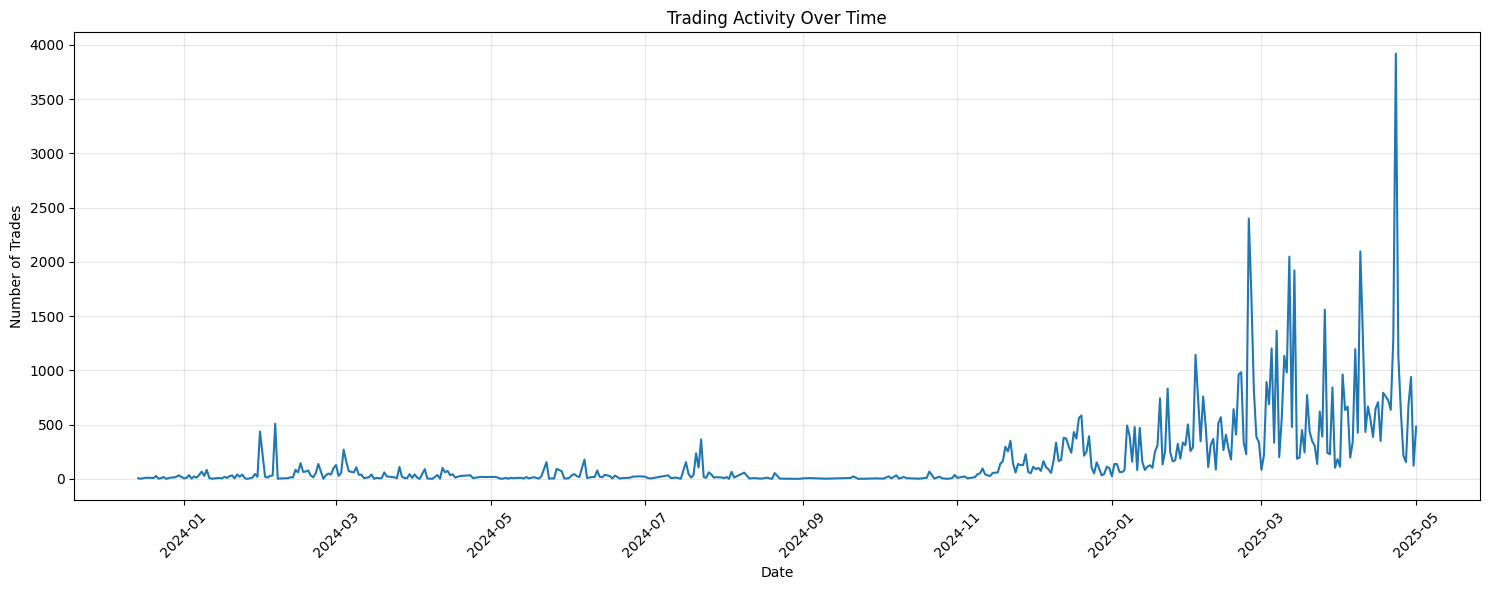


Date Analysis:
Date with most trades: 2025-04-23 (3920 trades)
Date with least trades: 2023-12-25 (1 trades)

Monthly Trading Activity:
month
2023-12      171
2024-01     1039
2024-02     1606
2024-03     1348
2024-04      619
2024-05      480
2024-06      731
2024-07     1227
2024-08      269
2024-09       55
2024-10      273
2024-11     2689
2024-12     6424
2025-01     7927
2025-02    16330
2025-03    19354
2025-04    23669
2025-05      481
Freq: M, dtype: int64

Top 5 Busiest Months:
  2025-04: 23669 trades
  2025-03: 19354 trades
  2025-02: 16330 trades
  2025-01: 7927 trades
  2024-12: 6424 trades


In [ ]:
# Add this analysis before the statistical summary

# Date-wise trading analysis using trade_date column
print("\nDate-wise Trading Analysis:")
date_wise_trades = merged.groupby('trade_date').size()
print(f"Total trading days: {len(date_wise_trades)}")
print(f"Average trades per day: {date_wise_trades.mean():.1f}")

# Top 10 most active dates
print("\nTop 10 Most Active Trading Dates:")
top_dates = date_wise_trades.sort_values(ascending=False).head(10)
for date, count in top_dates.items():
    print(f"  {date}: {count} trades")

# Plot date-wise trading activity
plt.figure(figsize=(15, 6))
date_wise_trades.sort_index().plot(kind='line')
plt.title('Trading Activity Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze if there are patterns in active trading dates
print(f"\nDate Analysis:")
print(f"Date with most trades: {date_wise_trades.idxmax()} ({date_wise_trades.max()} trades)")
print(f"Date with least trades: {date_wise_trades.idxmin()} ({date_wise_trades.min()} trades)")

# Monthly analysis
merged['month'] = pd.to_datetime(merged['trade_date']).dt.to_period('M')
monthly_trades = merged.groupby('month').size()
print(f"\nMonthly Trading Activity:")
print(monthly_trades)

# Top 5 busiest months
print(f"\nTop 5 Busiest Months:")
top_months = monthly_trades.sort_values(ascending=False).head(5)
for month, count in top_months.items():
    print(f"  {month}: {count} trades")

 Step 24: Final Insights

In [ ]:
# Generate key insights
print("\n" + "="*60)
print("KEY INSIGHTS AND CONCLUSIONS")
print("="*60)

# Insight 1: Sentiment impact
best_sentiment = sentiment_pnl.idxmax()
worst_sentiment = sentiment_pnl.idxmin()
print(f"\n1. SENTIMENT IMPACT:")
print(f"   • Best performing sentiment: {best_sentiment} (PnL: {sentiment_pnl[best_sentiment]:.6f})")
print(f"   • Worst performing sentiment: {worst_sentiment} (PnL: {sentiment_pnl[worst_sentiment]:.6f})")
if 'correlation' in locals():
    print(f"   • Sentiment-PnL correlation: {correlation:.4f} (very weak)")

# Insight 2: Trading patterns (Date-wise)
print(f"\n2. TRADING PATTERNS:")
print(f"   • Peak trading hour: {hourly_trades.idxmax():02d}:00 ({hourly_trades.max()} trades)")
print(f"   • Most active date: {most_active_date} ({most_active_date_count} trades)")
print(f"   • Total trading days analyzed: {len(date_wise_trades)}")
print(f"   • Average trades per day: {date_wise_trades.mean():.1f}")
print(f"   • Most popular coin: {coin_counts.index[0]} ({coin_counts.iloc[0]} trades)")

# Insight 3: Monthly patterns
if 'month' in merged.columns:
    busiest_month = monthly_trades.idxmax()
    print(f"   • Busiest month: {busiest_month} ({monthly_trades.max()} trades)")

# Insight 4: Data quality
missing_sentiment = merged['sentiment'].isna().sum()
print(f"\n3. DATA QUALITY:")
print(f"   • Missing sentiment data: {missing_sentiment} trades ({missing_sentiment/len(merged)*100:.1f}%)")
print(f"   • Total usable records: {len(merged):,}")

# Insight 5: Sentiment score analysis
if 'sentiment_score' in merged.columns:
    sentiment_correlation = merged['sentiment_score'].corr(merged['Closed PnL'])
    print(f"   • Sentiment score-PnL correlation: {sentiment_correlation:.4f}")

print(f"\nCONCLUSION:")
print("The analysis reveals subtle relationships between market sentiment and trading")
print("performance. While sentiment shows some variation in PnL, the correlation is")
print("weak, suggesting other factors may be more significant in determining trade outcomes.")
print(f"The trading activity shows clear temporal patterns with peak activity on {most_active_date}.")


KEY INSIGHTS AND CONCLUSIONS

1. SENTIMENT IMPACT:
   • Best performing sentiment: Fear (PnL: 0.466275)
   • Worst performing sentiment: Extreme Greed (PnL: 0.465959)
   • Sentiment-PnL correlation: -0.0188 (very weak)

2. TRADING PATTERNS:
   • Peak trading hour: 19:00 (5763 trades)
   • Most active date: 2025-04-23 (3920 trades)
   • Total trading days analyzed: 410
   • Average trades per day: 206.6
   • Most popular coin: HYPE (31985 trades)
   • Busiest month: 2025-04 (23669 trades)

3. DATA QUALITY:
   • Missing sentiment data: 6 trades (0.0%)
   • Total usable records: 84,692
   • Sentiment score-PnL correlation: -0.0188

CONCLUSION:
The analysis reveals subtle relationships between market sentiment and trading
performance. While sentiment shows some variation in PnL, the correlation is
weak, suggesting other factors may be more significant in determining trade outcomes.
The trading activity shows clear temporal patterns with peak activity on 2025-04-23.


In [ ]:
# Save the final merged dataset with all analysis
merged.to_csv('/content/drive/MyDrive/Colab Notebooks/Assignment/CSV_files/final_analysis_dataset.csv', index=False)

# Save summary statistics to a text file
with open('/content/drive/MyDrive/Colab Notebooks/Assignment/CSV_files/analysis_summary.txt', 'w') as f:
    f.write("CRYPTO TRADING SENTIMENT ANALYSIS - FINAL SUMMARY\n")
    f.write("="*50 + "\n\n")

    f.write(f"Total trades analyzed: {len(merged):,}\n")
    f.write(f"Analysis period: {merged['trade_date'].min()} to {merged['trade_date'].max()}\n")
    f.write(f"Unique coins: {merged['Coin'].nunique()}\n")
    f.write(f"Unique accounts: {merged['Account'].nunique()}\n\n")

    f.write("PNL BY SENTIMENT:\n")
    for sentiment, pnl in sentiment_pnl.items():
        f.write(f"  {sentiment}: {pnl:.6f}\n")

    f.write(f"\nCorrelation (sentiment vs PnL): {correlation:.4f}\n")

print("Analysis completed! Files saved:")
print("- final_analysis_dataset.csv")
print("- analysis_summary.txt")
print("- closed_trades.csv")
print("- open_trades.csv")
print("- system_events.csv")

Analysis completed! Files saved:
- final_analysis_dataset.csv
- analysis_summary.txt
- closed_trades.csv
- open_trades.csv
- system_events.csv
